In [1]:
# %matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import os
from pathlib import Path
import skimage.external.tifffile as tiff

from common import Statistics, dataset_source
from resources.conv_learner import *
from resources.plots import *
from pprint import pprint
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
PATH = "datasets/Kaggle_HPA_2018/"
data_path = Path(PATH)

In [5]:
NUM_CLASSES = 28
bs = 64
sz = [3,224,224]

In [6]:
# setting up a list of a random 20% of images in train as the validation set

lbl_csv = PATH + 'HPA_labels.csv'
n = len(list(open(lbl_csv))) -1
val_idxs = get_cv_idxs(n, val_pct=0.1)

In [7]:
def get_data(path, lbl_csv, val_idxs, sz, bs, aug_tfms):

    tfms = tfms_with_IntNorm(sz, aug_tfms=aug_tfms, crop_type=CropType.CENTER)
    data = ImageClassifierData.from_csv(PATH, 'full_train_BGR', lbl_csv, val_idxs = val_idxs, test_name='full_test_BGR', tfms=tfms, bs=bs, suffix = '.tiff', 
                                        balance=True)
    
    return data

In [8]:
# define augmentations
augs = [RandomDihedral()]

# initialize data object
data = get_data(PATH, lbl_csv, val_idxs, sz, bs, aug_tfms = augs)

weighted


### inpsect data_loaders

In [9]:
x, y = next(iter(data.trn_dl))
# x_test, y_test = next(iter(data.test_dl))

In [14]:
x.shape

torch.Size([64, 3, 224, 224])

In [ ]:
# loading epochs to inspect class-balance

In [ ]:
def load_epoch(dl = data.trn_dl):
    
    batch = iter(dl)

    xs = []
    ys = []

#     for b in range(0,len(dl)):
    for b in range(0,10):

        x_, y_ = next(batch)
        x_np, y_np = to_np(x_), to_np(y_)
        xs.append(x_np)
        ys.append(y_np)

    return np.vstack(xs), np.concatenate(ys)


In [ ]:
xs, ys = load_epoch()

In [ ]:
# analyze results
lbl_dist = ys.sum(axis=0)
print(lbl_dist)

In [ ]:
# weights calculation WIP

ys = data.trn_ds.y

cut = 1/len(data.classes)
perc = (ys.sum(axis=0) / ys.sum())

weights_per_label = [cut / perc[i] for i in range(len(data.classes))]
w_matrix = [ys[i] * weights_per_label for i in range(len(ys))]

min_weights_per_im = [np.min(w_matrix[i][np.nonzero(w_matrix[i])]) for i in range(len(ys))]
weights_per_im = [np.max(w_matrix[i]) for i in range(len(ys))]

In [ ]:
min_weights_per_im[:10]

### inpsecting loaded images and labels

In [10]:
def to_label(y):
    ind = [i for i, p in enumerate(y) if y[i]==1]
    return(ind)

[0, 9]


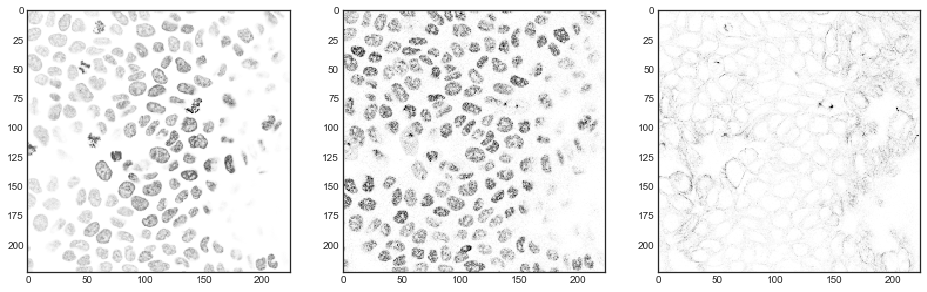

In [11]:
# inspect train images
plt.style.use('seaborn-white')

idx = 2

im = to_np(x)[idx]

lbl = to_label(to_np(y)[idx])
print(lbl)

fig, ax = plt.subplots(1,3, figsize=(16,10))
for i, ax in enumerate(ax.flat):
    ax.imshow(im[i])

In [ ]:
# inspect test images
plt.style.use('seaborn-white')

idx = 3

im = to_np(x_test)[idx]

# lbl = to_label(to_np(y)[idx])
# print(lbl)

fig, ax = plt.subplots(1,4, figsize=(16,10))
for i, ax in enumerate(ax.flat):
    ax.imshow(im[i])

# training

In [ ]:
torch.cuda.is_available()

In [27]:
out = '<function resnet18 at 0x0000026554E71598>'
if '_c' in out: 
    print('yes')

In [29]:
# base-model

# arch = resnet18_c
arch = resnet34
learn = ConvLearner.pretrained(arch, data, ps=0, opt_fn=optim.Adam, pretrained=True)

In [30]:
# additional parameters

wd=1e-5 # weight-decay/L2 regularization 
learn.metrics = [accuracy_thresh(0.5),f1_macro]

In [33]:
learn.unfreeze()

In [31]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 224, 224]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', False),
                           ('nb_params', 9408)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', False),
                           ('nb_params', 128)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 56, 56]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 64, 56, 

In [ ]:
learn.lr_find()

In [ ]:
learn.sched.plot()

In [ ]:
# training loops:

In [32]:
%time learn.fit(1e-2, 1, cycle_len=1, wds=wd, use_wd_sched=True)

EPOCH 0 ---------------------------------------- STEP 1                                                                                                                                                                                      
epoch      trn_loss   val_loss   <lambda>   f1_macro   
    0      0.197939   0.180055   0.944814   0.030667  

Wall time: 6min 32s


[array([0.18006]), 0.9448135554464369, 0.030666809563193446]

In [34]:
lr = (5e-4, 1e-3, 5e-3)

In [35]:
%time learn.fit(lr, 1, cycle_len=4, wds=wd, use_wd_sched=True, use_clr=(20,8, 0.95, 0.85))

EPOCH 0 ---------------------------------------- STEP 2                                                                                                                                                                                      
epoch      trn_loss   val_loss   <lambda>   f1_macro   
    0      0.132201   0.165034   0.943549   0.148452  
EPOCH 1 ---------------------------------------- STEP 3                                                                                                                                                                                      
    1      0.10198    0.148234   0.949457   0.231854  
  2%|███                                                                                                                                                                                         | 7/437 [00:12<12:59,  1.81s/it, loss=0.101]

KeyboardInterrupt: 

In [ ]:
learn.save('first_model_1epoch_balanced')

In [ ]:
log_preds, y = learn.predict_with_targs()

## test-predictions

In [ ]:
log_preds, y =  learn.predict_with_targs('test')

In [ ]:
# creating submission file
thresh = 0.2



clss = np.arange(0, len(data.classes)) # get class indeces
res = np.array([' '.join(np.char.mod('%d', clss[np.where(p > thresh)])) for p in log_preds]) # generating output

# ensure that there are no empty cells: in case no value > thresh, fill in with argmax()
for i in range(res.shape[0]):
    if res[i] == '':
        res[i] = log_preds[i].argmax()

# getting image Ids
fnames = np.array([os.path.basename(im).split('.')[0] for im in data.test_ds.fnames])

# creating submission file
sub_df = pd.DataFrame(res, index=fnames, columns=['Predicted'])
sub_df.to_csv(f"{PATH}submissions/Test_submission_thresh_02.csv", index_label='Id')

## other stuff

In [ ]:
# List of label identities:

cell_location_label = {
0:  'Nucleoplasm',
1:  'Nuclear membrane',
2:  'Nucleoli',   
3:  'Nucleoli fibrillar center',
4:  'Nuclear speckles',
5:  'Nuclear bodies',
6:  'Endoplasmic reticulum',   
7:  'Golgi apparatus',
8:  'Peroxisomes',
9:  'Endosomes',
10:  'Lysosomes',
11:  'Intermediate filaments',
12:  'Actin filaments',
13:  'Focal adhesion sites',   
14:  'Microtubules',
15:  'Microtubule ends',  
16:  'Cytokinetic bridge',   
17:  'Mitotic spindle',
18:  'Microtubule organizing center',  
19:  'Centrosome',
20:  'Lipid droplets',
21:  'Plasma membrane',   
22:  'Cell junctions', 
23:  'Mitochondria',
24:  'Aggresome',
25:  'Cytosol',
26:  'Cytoplasmic bodies',   
27:  'Rods & rings' }